<a href="https://colab.research.google.com/github/kaeyang/KDE-Analysts/blob/main/KDE_Analyst_exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Data Analysis

## 1.1 Basic Setup

In [ ]:
# Import 3rd party libraries
import os
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 72

In [ ]:
import numpy as np

In [ ]:
!pip install geopandas

In [ ]:
!pip install descartes

In [ ]:
# Initial Settings

pd.options.mode.chained_assignment = None  # default='warn'

Import file from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import geopandas as gpd

## 1.2 Import cleaned data

The clean data have been completed in the previous section, including the data from year 2017 to 2020.

In [ ]:
#specified with my google drive path, to be changed if running in other platform.
clean_data=pd.read_csv('/content/drive/MyDrive/UT/Courses/Winter2021/CIV1498/Project/clean_data.csv').drop(columns='Unnamed: 0')

In [ ]:
#clean_data = pd.read_csv("clean_data.csv").drop(columns='Unnamed: 0')
clean_data['Start Time'] = pd.to_datetime(clean_data['Start Time'], utc=True).dt.tz_convert('EST')
clean_data['End Time'] = pd.to_datetime(clean_data['End Time'], utc=True).dt.tz_convert('EST')
clean_data.head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,Start Latitude,Start Longitude,Start Capacity,End Latitude,End Longitude,End Capacity,User Type,Merge Time,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006,Bay St / College St (East Side),7021,Bay St / Albert St,43.660439,-79.385525,11.0,43.653264,-79.382458,35.0,Annual Member,2017-01-01 00:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359.0,2017.0,1.0,1.0,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046,Niagara St / Richmond St W,7147,King St W / Fraser Ave,43.645340,-79.409597,26.0,43.639444,-79.425278,15.0,Annual Member,2017-01-01 00:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359.0,2017.0,1.0,1.0,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048,Front St / Yonge St (Hockey Hall of Fame),7089,Church St / Wood St,43.646144,-79.377962,47.0,43.662712,-79.379903,19.0,Annual Member,2017-01-01 00:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359.0,2017.0,1.0,1.0,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177,East Liberty St / Pirandello St,7202,Queen St W / York St (City Hall),43.638611,-79.414722,19.0,43.651667,-79.384167,31.0,Annual Member,2017-01-01 00:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359.0,2017.0,1.0,1.0,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203,Bathurst St/Queens Quay(Billy Bishop Airport),7010,King St W / Spadina Ave,43.635492,-79.398253,35.0,43.645323,-79.395003,19.0,Annual Member,2017-01-01 00:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359.0,2017.0,1.0,1.0,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN


## 1.3 Trend of usage

The number of the rides is plotted according to each month (cumulated each month) from 2017-01 to 2020-12. 

In [ ]:
#Separate data based on member, and resample on a monthly basis
trips_data_reset = clean_data.set_index(pd.DatetimeIndex
                                        (clean_data['Start Time']))
trips_data_reset_ann = trips_data_reset[trips_data_reset['User Type']=='Annual Member']
trips_data_reset_cas = trips_data_reset[trips_data_reset['User Type']=='Casual Member']

trips_data_month_ann = trips_data_reset_ann.resample('M').count()
trips_data_month_cas = trips_data_reset_cas.resample('M').count()

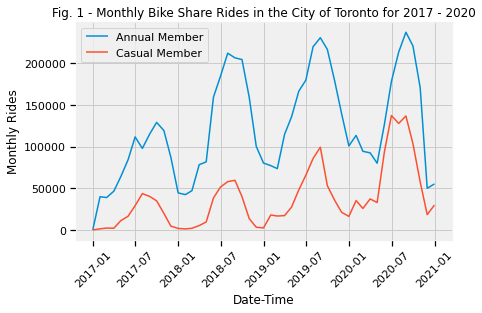

In [ ]:
ax = sns.lineplot(data=trips_data_month_ann['Trip Id'])
ax = sns.lineplot(data=trips_data_month_cas['Trip Id'])
ax.set_ylabel('Monthly Rides')
ax.set_xlabel('Date-Time')
plt.xticks(rotation=45)
ax.set_title('Fig. 1 - Monthly Bike Share Rides in the City of Toronto for 2017 - 2020')
ax.legend(labels=['Annual Member','Casual Member'])

plt.show()

From the above plot, there is a clear increasing trend of usage of bike share from 2017 to 2020. And both annual members and casual members show the same trend. 

## 1.4 Effect of Lockdowns

The monthly number of rides are plotted for 2020, comparing to the average of 2017-2019, for a monthly trend of the usage of the system. If there is abnormal trend in 2020 near the lockdown, it means lockdown will have effect. Besides, annual members and casual members are plotted separately.

In [ ]:
trips_data_month = trips_data_month_ann[['Trip Id']].rename(columns={'Trip Id':'trips_ann'})
trips_data_month['trips_cas'] = trips_data_month_cas['Trip Id']
trips_data_month = trips_data_month.reset_index()
trips_data_month['month'] = trips_data_month['Start Time'].dt.month
trips_data_month['year'] = trips_data_month['Start Time'].dt.year
trips_data_month = trips_data_month.drop(columns=['Start Time']).drop([0])

trips_data_month_2020 = trips_data_month[trips_data_month['year']==2020]
trips_data_month_non2020 = trips_data_month[trips_data_month['year']!=2020]

trips_data_month_2020_plot = trips_data_month_2020.drop(columns=['year'])#.set_index('month')
trips_data_month_non2020_plot = trips_data_month_non2020.groupby('month').mean().drop(columns=['year']).reset_index()

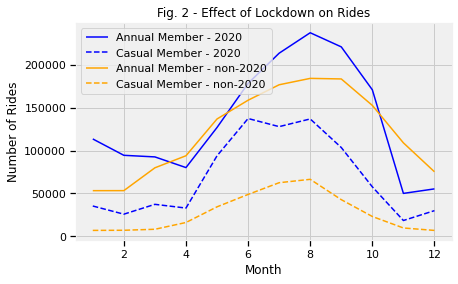

In [ ]:
ax = sns.lineplot(x=trips_data_month_2020_plot['month'],y=trips_data_month_2020_plot['trips_ann'],color='blue')
ax = sns.lineplot(x=trips_data_month_2020_plot['month'],y=trips_data_month_2020_plot['trips_cas'],color='blue',linestyle='--')
ax = sns.lineplot(x=trips_data_month_non2020_plot['month'],y=trips_data_month_non2020_plot['trips_ann'],color='orange')
ax = sns.lineplot(x=trips_data_month_non2020_plot['month'],y=trips_data_month_non2020_plot['trips_cas'],color='orange',linestyle='--')

ax.set_ylabel('Number of Rides')
ax.set_xlabel('Month')
ax.set_title('Fig. 2 - Effect of Lockdown on Rides')
ax.legend(labels=['Annual Member - 2020','Casual Member - 2020',
                  'Annual Member - non-2020','Casual Member - non-2020'])
plt.show()

The annual member drops significantly around March and April, at the pandemic intial outbreak. That reflects that many people starts to work from home, which results in the reduced needs. When the lockdown was release, the number annual member had an significant increase around August. But when the second wave hits, the number dropped again at around November.  
Casual member has similar trend.

## 1.5 Usage Behaviour

Usage across the day. The hourly average number of rides is plotted against the hour of day. It turns out annual members tend to use in rush hours, casual members tend to use more in afternoon rush hours. And annual members will use more than casual members.

In [ ]:
trips_data = trips_data_reset[['Trip Id','User Type']].reset_index()

trips_data_hour_by_member = trips_data.groupby([trips_data['Start Time'].dt.floor('h'),'User Type']).agg({'Trip Id': len}).reset_index()
trips_data_hour_ann = trips_data_hour_by_member[trips_data_hour_by_member['User Type']=='Annual Member']
trips_data_hour_ann_mean = trips_data_hour_ann.groupby(by=trips_data_hour_ann['Start Time'].dt.hour).mean()

trips_data_hour_cas = trips_data_hour_by_member[trips_data_hour_by_member['User Type']=='Casual Member']
trips_data_hour_cas_mean = trips_data_hour_cas.groupby(by=trips_data_hour_cas['Start Time'].dt.hour).mean()

trips_data_hour_mean = trips_data_hour_ann_mean[['Trip Id']].rename(columns={'Trip Id':'trips_ann'})
trips_data_hour_mean['trips_cas'] =  trips_data_hour_cas_mean[['Trip Id']]

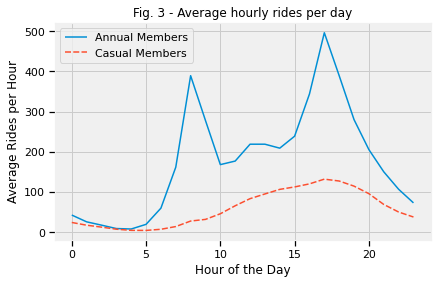

In [ ]:
ax = sns.lineplot(data=trips_data_hour_mean)

ax.set_ylabel('Average Rides per Hour')
ax.set_xlabel('Hour of the Day')
ax.set_title('Fig. 3 - Average hourly rides per day')
ax.legend(labels=['Annual Members','Casual Members'])

plt.show()

Usage across the week. The daily average number of rides is plotted against the day in a week. It turns out annual members use it more in weekdays, but casual members will use more on weekends.

In [ ]:
trips_data_day_by_member = trips_data.groupby([trips_data['Start Time'].dt.floor('d'),'User Type']).agg({'Trip Id': len}).reset_index()

trips_data_day_ann = trips_data_day_by_member[trips_data_day_by_member['User Type']=='Annual Member']
trips_data_day_ann_mean = trips_data_day_ann.groupby(by=trips_data_day_ann['Start Time'].dt.weekday).mean()

trips_data_day_cas = trips_data_day_by_member[trips_data_day_by_member['User Type']=='Casual Member']
trips_data_day_cas_mean = trips_data_day_cas.groupby(by=trips_data_day_cas['Start Time'].dt.weekday).mean()

trips_data_day_mean = trips_data_day_ann_mean.rename(columns={'Trip Id':'trips_ann'})
trips_data_day_mean['trips_cas'] = trips_data_day_cas_mean['Trip Id']

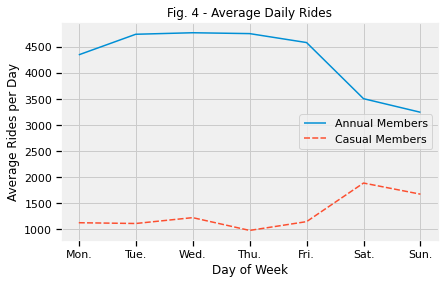

In [ ]:
ax = sns.lineplot(data=trips_data_day_mean)

ax.set_ylabel('Average Rides per Day')
ax.set_xlabel('Day of Week')
ax.set_title('Fig. 4 - Average Daily Rides')
ax.legend(labels=['Annual Members','Casual Members'])
ax.set_xticklabels(['','Mon.','Tue.','Wed.','Thu.','Fri.','Sat.','Sun.'])

plt.show()

Compare usage across the day between weekdays and weekends

In [ ]:
trips_data_hour_by_member['day_of_week']=trips_data_hour_by_member['Start Time'].dt.weekday

trips_data_hr_weekday = trips_data_hour_by_member[trips_data_hour_by_member['day_of_week'].isin([0,1,2,3,4])]
trips_data_hr_weekend = trips_data_hour_by_member[trips_data_hour_by_member['day_of_week'].isin([5,6])]

trips_data_hr_weekday_ann = trips_data_hr_weekday[trips_data_hr_weekday['User Type']=='Annual Member']
trips_data_hr_weekday_cas = trips_data_hr_weekday[trips_data_hr_weekday['User Type']=='Casual Member']

trips_data_hr_weekend_ann = trips_data_hr_weekend[trips_data_hr_weekend['User Type']=='Annual Member']
trips_data_hr_weekend_cas = trips_data_hr_weekend[trips_data_hr_weekend['User Type']=='Casual Member']

trips_data_hr_weekday_ann_mean = trips_data_hr_weekday_ann.groupby(by=trips_data_hr_weekday_ann['Start Time'].dt.hour).mean()
trips_data_hr_weekday_cas_mean = trips_data_hr_weekday_cas.groupby(by=trips_data_hr_weekday_cas['Start Time'].dt.hour).mean()

trips_data_hr_weekend_ann_mean = trips_data_hr_weekend_ann.groupby(by=trips_data_hr_weekend_ann['Start Time'].dt.hour).mean()
trips_data_hr_weekend_cas_mean = trips_data_hr_weekend_cas.groupby(by=trips_data_hr_weekend_cas['Start Time'].dt.hour).mean()

trips_data_hr_mean = trips_data_hr_weekday_ann_mean[['Trip Id']].rename(columns={'Trip Id':'trips_weekday_ann'})
trips_data_hr_mean['trips_weekday_cas'] = trips_data_hr_weekday_cas_mean[['Trip Id']]
trips_data_hr_mean['trips_weekend_ann'] = trips_data_hr_weekend_ann_mean[['Trip Id']]
trips_data_hr_mean['trips_weekend_cas'] = trips_data_hr_weekend_cas_mean[['Trip Id']]

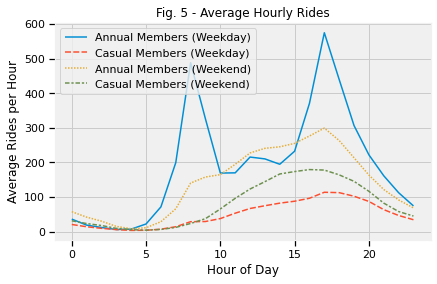

In [ ]:
ax = sns.lineplot(data=trips_data_hr_mean)

ax.set_ylabel('Average Rides per Hour')
ax.set_xlabel('Hour of Day')
ax.set_title('Fig. 5 - Average Hourly Rides')
ax.legend(labels=['Annual Members (Weekday)','Casual Members (Weekday)','Annual Members (Weekend)','Casual Members (Weekend)'])

plt.show()

Usage across the year. People tend to use the system more during the summer.

In [ ]:
trips_data_month_by_member = trips_data
trips_data_month_by_member['month_of_year'] = trips_data_month_by_member['Start Time'].dt.month
trips_data_month_by_member = trips_data_month_by_member.groupby(['month_of_year','User Type']).agg({'Trip Id': len}).reset_index()

trips_data_month_ann =  trips_data_month_by_member[trips_data_month_by_member['User Type']=='Annual Member']
trips_data_month_cas =  trips_data_month_by_member[trips_data_month_by_member['User Type']=='Casual Member']

trips_data_month_ann_mean = trips_data_month_ann.groupby('month_of_year').mean()
trips_data_month_cas_mean = trips_data_month_cas.groupby('month_of_year').mean()
trips_data_month_mean = trips_data_month_ann_mean[['Trip Id']].rename(columns={'Trip Id': 'trips_ann'})
trips_data_month_mean['trips_cas'] = trips_data_month_cas_mean[['Trip Id']]

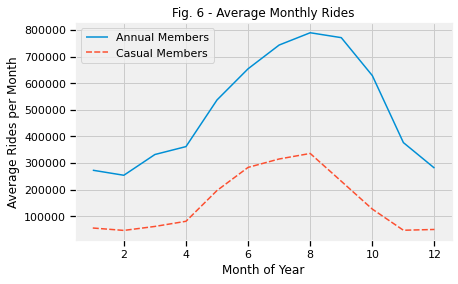

In [ ]:
ax = sns.lineplot(data=trips_data_month_mean)

ax.set_ylabel('Average Rides per Month')
ax.set_xlabel('Month of Year')
ax.set_title('Fig. 6 - Average Monthly Rides')
ax.legend(labels=['Annual Members','Casual Members'])
#ax.set_xticklabels(['','Jan.','Feb.','Mar.','Apr.','Ma.','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.'])

plt.show()

## 1.6 Trip Duration - Seasonal Trend

In [ ]:
Trips_data_duration_season = trips_data_reset[['User Type','Trip Duration']].reset_index()
Trips_data_duration_season_ann = Trips_data_duration_season[Trips_data_duration_season['User Type']=='Annual Member']
Trips_data_duration_season_cas = Trips_data_duration_season[Trips_data_duration_season['User Type']=='Casual Member']

Trips_data_duration_season_ann_mean = Trips_data_duration_season_ann.groupby(Trips_data_duration_season_ann['Start Time'].dt.month).mean().rename(columns={'Trip Duration':'trip_dur_ann'})
Trips_data_duration_season_cas_mean = Trips_data_duration_season_cas.groupby(Trips_data_duration_season_cas['Start Time'].dt.month).mean().rename(columns={'Trip Duration':'trip_dur_cas'})
Trips_data_duration_season_mean = Trips_data_duration_season_ann_mean
Trips_data_duration_season_mean['trip_dur_cas'] =  Trips_data_duration_season_cas_mean['trip_dur_cas']

Trips_data_duration_season_mean

,trip_dur_ann,trip_dur_cas
Start Time,,
1,659.931013,1094.160548
2,655.578472,1060.658291
3,662.893729,1086.215296
4,679.204040,1091.130226
5,716.398428,1121.717665
6,728.755246,1100.111887
7,729.413612,1088.178685
8,723.038426,1079.308872
9,704.760088,1054.021752


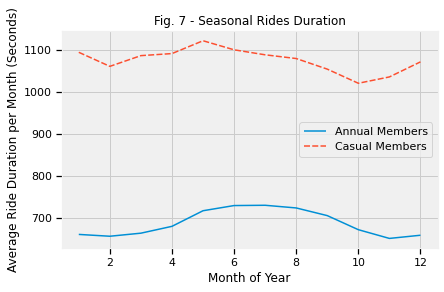

In [ ]:
ax = sns.lineplot(data=Trips_data_duration_season_mean)

ax.set_ylabel('Average Ride Duration per Month (Seconds)')
ax.set_xlabel('Month of Year')
ax.set_title('Fig. 7 - Seasonal Rides Duration')
ax.legend(labels=['Annual Members','Casual Members'])
#ax.set_xticklabels(['','Jan.','Feb.','Mar.','Apr.','Ma.','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.'])

plt.show()

From the plot above, it is clear that the average trip duration during the summer is higher than that in the winter. And casual members tend to ride longer than annual members in general.

## 1.7 Statutory Holidays Effect

In [ ]:
toronto_holidays = pd.Series(['2017-01-01','2017-02-20','2017-04-14','2017-05-22','2017-07-01','2017-08-07','2017-09-04','2017-10-09','2017-12-25','2017-12-26',
'2018-01-01','2018-02-19','2018-03-30','2018-05-21','2018-07-01','2018-08-06','2018-09-03','2018-10-08','2018-12-25','2018-12-26',
'2019-01-01','2019-02-18','2019-04-19','2019-05-20','2019-07-01','2019-08-05','2019-09-02','2019-10-14','2019-12-25','2019-12-26',
'2020-01-01','2020-02-17','2020-04-10','2020-05-18','2020-07-01','2020-08-03','2020-09-07','2020-10-12','2020-12-25','2020-12-26'])#.tz_localize('EST')

toronto_holidays = pd.to_datetime(toronto_holidays).dt.date

In [ ]:
trips_data_hour_by_member['holiday'] = trips_data_hour_by_member['Start Time'].dt.date.isin(toronto_holidays)

trips_data_hour_by_member

trips_data_hr_weekend_ann = trips_data_hour_by_member[(trips_data_hour_by_member['User Type']=='Annual Member')&(trips_data_hour_by_member['day_of_week'].isin([5,6]))]
trips_data_hr_weekend_cas = trips_data_hour_by_member[(trips_data_hour_by_member['User Type']=='Casual Member')&(trips_data_hour_by_member['day_of_week'].isin([5,6]))]

trips_data_hr_holiday_ann = trips_data_hour_by_member[(trips_data_hour_by_member['User Type']=='Annual Member')&(trips_data_hour_by_member['holiday']==True)]
trips_data_hr_holiday_cas = trips_data_hour_by_member[(trips_data_hour_by_member['User Type']=='Casual Member')&(trips_data_hour_by_member['holiday']==True)]

trips_data_hr_weekend_ann_mean = trips_data_hr_weekend_ann.groupby(trips_data_hr_weekend_ann['Start Time'].dt.hour).mean()
trips_data_hr_weekend_cas_mean = trips_data_hr_weekend_cas.groupby(trips_data_hr_weekend_cas['Start Time'].dt.hour).mean()

trips_data_hr_holiday_ann_mean = trips_data_hr_holiday_ann.groupby(trips_data_hr_holiday_ann['Start Time'].dt.hour).mean()
trips_data_hr_holiday_cas_mean = trips_data_hr_holiday_cas.groupby(trips_data_hr_holiday_cas['Start Time'].dt.hour).mean()

trips_data_hr_holiday = trips_data_hr_weekend_ann_mean[['Trip Id']].rename(columns={'Trip Id':'trips_weekend_ann'})
trips_data_hr_holiday['trips_weekend_cas'] = trips_data_hr_weekend_cas_mean['Trip Id']
trips_data_hr_holiday['trips_holiday_ann'] = trips_data_hr_holiday_ann_mean['Trip Id']
trips_data_hr_holiday['trips_holiday_cas'] = trips_data_hr_holiday_cas_mean['Trip Id']


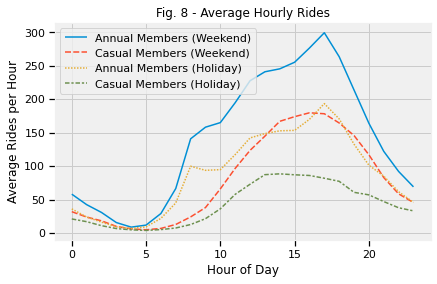

In [ ]:
ax = sns.lineplot(data=trips_data_hr_holiday)

ax.set_ylabel('Average Rides per Hour')
ax.set_xlabel('Hour of Day')
ax.set_title('Fig. 8 - Average Hourly Rides')
ax.legend(labels=['Annual Members (Weekend)','Casual Members (Weekend)','Annual Members (Holiday)','Casual Members (Holiday)'])

plt.show()

The usage on stat holidays are compared to that on regular weekends, since people don't have to work in both cases. But it turns out on stat holidays, the usage is much less than that on regular weekends, which means people tend not to use the bike share on holidays.

## 1.8 Free Ride Wednesdays

According to the website, free ride Wednesdays happen every Wednesday during September. In this case, the number of rides are plotted based on the day of the week, where the September curves are compared to the rest of the months. The numbers of rides are averaged according to the day of the week, which will be more comparative. 

In [ ]:
trips_data_to_count = trips_data_reset[['User Type']]
trips_data_to_count_ann = trips_data_to_count[trips_data_to_count['User Type']=='Annual Member']
trips_data_to_count_cas = trips_data_to_count[trips_data_to_count['User Type']=='Casual Member']

In [ ]:
trips_data_free_wed_ann = trips_data_to_count_ann.resample('D').count().rename(columns={'User Type':'trips_ann'})
trips_data_free_wed_cas = trips_data_to_count_cas.resample('D').count().rename(columns={'User Type':'trips_cas'})
trips_data_free_wed = trips_data_free_wed_ann.merge(trips_data_free_wed_cas, 
                                                    how='outer',left_index=True,right_index=True).reset_index()
trips_data_free_wed['month'] = trips_data_free_wed['Start Time'].dt.month
trips_data_free_wed['day_of_week'] = trips_data_free_wed['Start Time'].dt.weekday

trips_data_free_wed = trips_data_free_wed.drop(columns=['Start Time']).drop([0])

trips_data_free_wed_sep = trips_data_free_wed[trips_data_free_wed['month']==9]
trips_data_free_wed_other = trips_data_free_wed[trips_data_free_wed['month']!=9]

trips_data_free_wed_sep_plot = trips_data_free_wed_sep.groupby('day_of_week').mean().reset_index()
trips_data_free_wed_other_plot = trips_data_free_wed_other.groupby('day_of_week').mean().reset_index()
#trips_data_free_wed_sep_plot

In [ ]:
trips_data_free_wed_jun = trips_data_free_wed[trips_data_free_wed['month'].isin([6,7,8])]
trips_data_free_wed_jun_plot = trips_data_free_wed_jun.groupby('day_of_week').mean().reset_index()

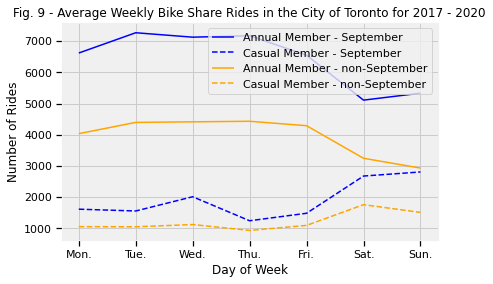

In [ ]:
ax = sns.lineplot(x=trips_data_free_wed_sep_plot['day_of_week'],y=trips_data_free_wed_sep_plot['trips_ann'],color='blue')
ax = sns.lineplot(x=trips_data_free_wed_sep_plot['day_of_week'],y=trips_data_free_wed_sep_plot['trips_cas'],color='blue',linestyle='--')
ax = sns.lineplot(x=trips_data_free_wed_other_plot['day_of_week'],y=trips_data_free_wed_other_plot['trips_ann'],color='orange')
ax = sns.lineplot(x=trips_data_free_wed_other_plot['day_of_week'],y=trips_data_free_wed_other_plot['trips_cas'],color='orange',linestyle='--')

ax.set_ylabel('Number of Rides')
ax.set_xlabel('Day of Week')
ax.set_title('Fig. 9 - Average Weekly Bike Share Rides in the City of Toronto for 2017 - 2020')
ax.legend(labels=['Annual Member - September','Casual Member - September',
                  'Annual Member - non-September','Casual Member - non-September'])
ax.set_xticklabels(['','Mon.','Tue.','Wed.','Thu.','Fri.','Sat.','Sun.'])
plt.show()

It seems like the September curves are generally higher than the rest, that's because the rest curves taking into consideration of months in the winters, so they may not be very representative. Therefore, the September curves are only compared with the average of the other 3 summer months (June, July, August). 

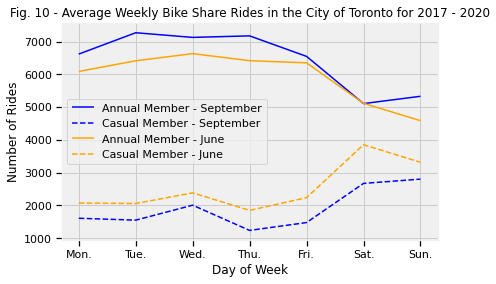

In [ ]:
ax = sns.lineplot(x=trips_data_free_wed_sep_plot['day_of_week'],y=trips_data_free_wed_sep_plot['trips_ann'],color='blue')
ax = sns.lineplot(x=trips_data_free_wed_sep_plot['day_of_week'],y=trips_data_free_wed_sep_plot['trips_cas'],color='blue',linestyle='--')
ax = sns.lineplot(x=trips_data_free_wed_jun_plot['day_of_week'],y=trips_data_free_wed_jun_plot['trips_ann'],color='orange')
ax = sns.lineplot(x=trips_data_free_wed_jun_plot['day_of_week'],y=trips_data_free_wed_jun_plot['trips_cas'],color='orange',linestyle='--')

ax.set_ylabel('Number of Rides')
ax.set_xlabel('Day of Week')
ax.set_title('Fig. 10 - Average Weekly Bike Share Rides in the City of Toronto for 2017 - 2020')
ax.legend(labels=['Annual Member - September','Casual Member - September',
                  'Annual Member - June','Casual Member - June'])
ax.set_xticklabels(['','Mon.','Tue.','Wed.','Thu.','Fri.','Sat.','Sun.'])
plt.show()

It is clear that casual member usage on Wednesdays in September sees a jump, which means it attracts people to use the system. 

## 1.9 Effect of Weather

This part plots the chart of the rides versus the weather.

In [ ]:
trips_data_weather = trips_data_reset[['Trip Id','Weather']].fillna('Clear')
trips_data_weather_group = (trips_data_weather.groupby('Weather').agg(len)
                            .rename(columns={'Trip Id':'trip_counts'})
                            .sort_values('trip_counts',ascending=False)
                            .reset_index())

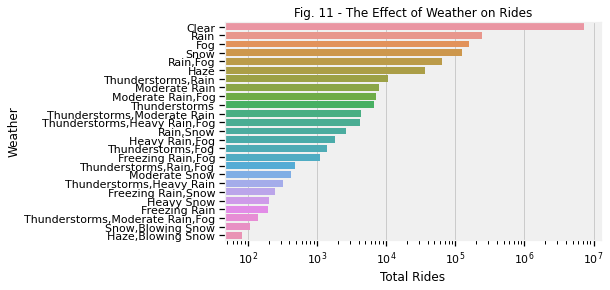

In [ ]:
ax = sns.barplot(x='trip_counts', y='Weather', data=trips_data_weather_group)

ax.set_ylabel('Weather')
ax.set_xlabel('Total Rides')
ax.set(xscale='log',xticklabels=[])
ax.set_title('Fig. 11 - The Effect of Weather on Rides')

plt.show()

This part plots the chart of the rides versus the Temperature. The number of rides has been averaged on an hourly basis, which is also the frequency of the weather sampling.

In [ ]:
trips_data_temp = trips_data_reset[['Trip Id','Temp (°C)']]
#trips_data_temp_group = (trips_data_temp.groupby('Temp (°C)').agg(len)
#                            .rename(columns={'Trip Id':'trip_counts'})
#                            .sort_values('Temp (°C)'))

trips_data_temp_time_index = trips_data_temp.reset_index()
trips_data_temp_resample = (trips_data_temp_time_index.groupby(trips_data_temp_time_index['Start Time'].dt.floor('h'))
                              .agg({'Temp (°C)':'mean','Trip Id':'size'})
                              .rename(columns={'Trip Id':'trips'})
                              .reset_index()).drop([0,1,2,3])
trips_data_temp_resample['Temp (°C)'] = trips_data_temp_resample['Temp (°C)'].round(decimals = 1)

trips_data_temp_mean =  trips_data_temp_resample.groupby('Temp (°C)').mean().reset_index().sort_values('Temp (°C)').set_index('Temp (°C)')
trips_data_temp_mean.head()

,trips
Temp (°C),
-21.9,5.0
-21.8,1.0
-21.6,12.0
-20.9,8.0
-20.8,4.0


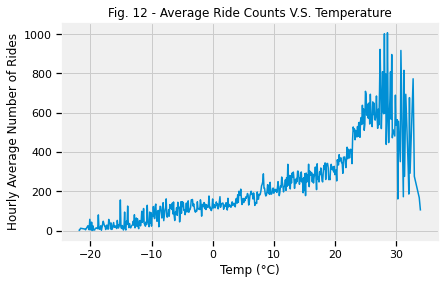

In [ ]:
ax = sns.lineplot(data=trips_data_temp_mean['trips'])

ax.set_ylabel('Hourly Average Number of Rides')
ax.set_title('Fig. 12 - Average Ride Counts V.S. Temperature')
plt.show()

This part plots the chart of the rides versus the humidity.

In [ ]:
trips_data_humi = trips_data_reset[['Trip Id','Rel Hum (%)']].rename(columns={'Rel Hum (%)':'Humidity'})
trips_data_humi_group = (trips_data_humi.groupby(by='Humidity').agg(len)
                            .rename(columns={'Trip Id':'trip_counts'})
                            .sort_values('Humidity'))

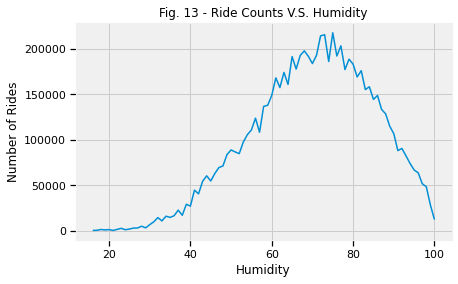

In [ ]:
ax = sns.lineplot(data=trips_data_humi_group['trip_counts'])

ax.set_ylabel('Number of Rides')
ax.set_title('Fig. 13 - Ride Counts V.S. Humidity')
plt.show()

This part plots the chart of the rides versus wind speed.

In [ ]:
trips_data_windsp = trips_data_reset[['Trip Id','Wind Spd (km/h)']].rename(columns={'Wind Spd (km/h)':'Wind Speed (km/h)'})
trips_data_windsp_group = (trips_data_windsp.groupby(by='Wind Speed (km/h)').agg(len)
                            .rename(columns={'Trip Id':'trip_counts'})
                            .sort_values('Wind Speed (km/h)'))

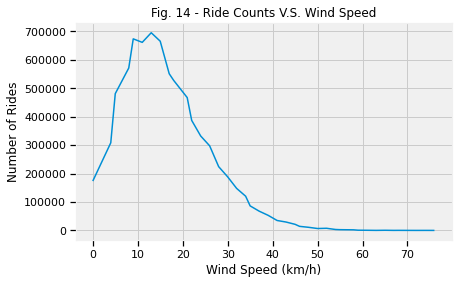

In [ ]:
ax = sns.lineplot(data=trips_data_windsp_group['trip_counts'])

ax.set_ylabel('Number of Rides')
ax.set_title('Fig. 14 - Ride Counts V.S. Wind Speed')
plt.show()

This part plots the chart of the rides versus visibility.

In [ ]:
trips_data_visi = trips_data_reset[['Trip Id','Visibility (km)']]
trips_data_visi_group = (trips_data_visi.groupby(by='Visibility (km)').agg(len)
                            .rename(columns={'Trip Id':'trip_counts'})
                            .sort_values('Visibility (km)'))

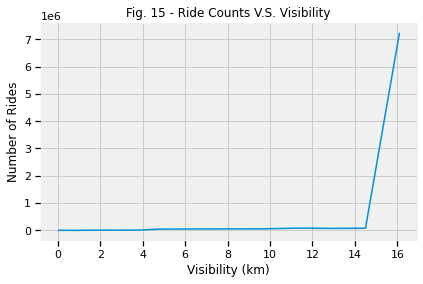

In [ ]:
ax = sns.lineplot(data=trips_data_visi_group['trip_counts'])

ax.set_ylabel('Number of Rides')
ax.set_title('Fig. 15 - Ride Counts V.S. Visibility')
plt.show()

This part plots the chart of the rides versus atmosphere pressure.

In [ ]:
trips_data_ap = trips_data_reset[['Trip Id','Stn Press (kPa)']].rename(columns={'Stn Press (kPa)':'Atmosphere Press (kPa)'})
trips_data_ap_group = (trips_data_ap.groupby(by='Atmosphere Press (kPa)').agg(len)
                            .rename(columns={'Trip Id':'trip_counts'})
                            .sort_values('Atmosphere Press (kPa)'))

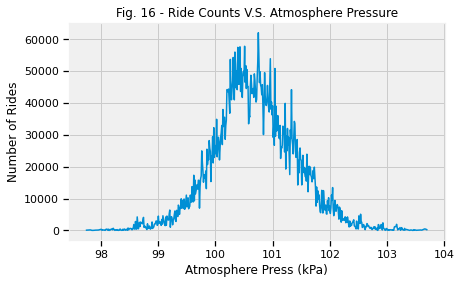

In [ ]:
ax = sns.lineplot(data=trips_data_ap_group['trip_counts'])

ax.set_ylabel('Number of Rides')
ax.set_title('Fig. 16 - Ride Counts V.S. Atmosphere Pressure')
plt.show()

It seems like the number of trips will be affected by many different weather factors. Therefore, it will be interesting to see how different weather factors will act together to affect the rides. 
In the following, temperature and wind speed, as well as the weather conditions are considered.

In [ ]:
trips_data_weather_comb_time_index = trips_data_reset[['Start Time','Weather','Temp (°C)','Wind Spd (km/h)']]
trips_data_weather_comb_time_index['Weather'] = trips_data_weather_comb_time_index['Weather'].fillna('Clear')

trips_data_weather_comb_time_index.loc[trips_data_weather_comb_time_index['Weather']!='Clear','Weather']='Precipitation'
trips_data_weather_comb_time_index = trips_data_weather_comb_time_index.drop(columns=['Start Time']).reset_index().reset_index()

trips_data_weather_comb_time_index[['Temp (°C)','Wind Spd (km/h)']] = trips_data_weather_comb_time_index[['Temp (°C)','Wind Spd (km/h)']].astype(float)

Input select_year and select_month for plot in a select month.

In [ ]:
select_year = 2017
select_month = 3

trips_select = trips_data_weather_comb_time_index[(trips_data_weather_comb_time_index['Start Time'].dt.year==select_year)&(trips_data_weather_comb_time_index['Start Time'].dt.month==select_month)]
start_trip_select = trips_select.iloc[0]['index']
end_trip_select = trips_select.sort_values('index',ascending=False).iloc[0]['index']

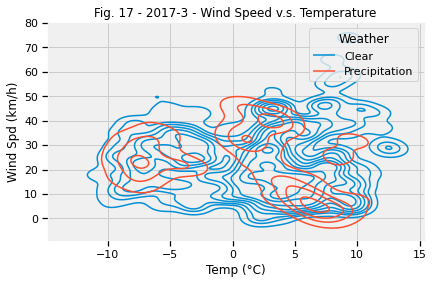

In [ ]:
trips_data_weather_comb_sample = trips_data_weather_comb_time_index.loc[start_trip_select:end_trip_select,:]
trips_data_weather_comb_sample
ax=sns.kdeplot(data=trips_data_weather_comb_sample,x='Temp (°C)',y='Wind Spd (km/h)',hue='Weather',fill=False)
ax.set_title('Fig. 17 - {:0.0f}-{:0.0f} - Wind Speed v.s. Temperature'.format(select_year,select_month))
plt.show()

The contour plot shows the combined effect of temperature, wind speed, and precipitation in a certain month (due to the limitation of RAM, I was unable to plot for the overall database). It turns out people will have much more usage in clear weathers. 

## 1.10 How People Using the System

Trips happened during weekdays's rush hours (7am - 10am & 4pm - 7pm) are considered for commute purpose, while other trips are considered for city exploratory purposes.

In [ ]:
trips_data_commute_explore = trips_data_reset[['Trip Id','Time']].reset_index()
trips_data_commute_explore['day_of_week'] = trips_data_commute_explore['Start Time'].dt.weekday
#trips_data_commute_explore.info()

In [ ]:
trips_data_commute = trips_data_commute_explore[(trips_data_commute_explore['Start Time'].dt.hour.isin([7,8,9,16,17,18]) & trips_data_commute_explore['day_of_week'].isin([0,1,2,3,4]))]
trips_data_explore =  trips_data_commute_explore[(~trips_data_commute_explore['Start Time'].dt.hour.isin([7,8,9,16,17,18]) | ~trips_data_commute_explore['day_of_week'].isin([0,1,2,3,4]))]

In [ ]:
trips_data_commute_percentage = trips_data_commute.shape[0] / trips_data_commute_explore.shape[0] *100
trips_data_explore_percentage = 100 - trips_data_commute_percentage
print('{:0.2f} % of trips are for commuting, while {:0.2f} % of trips are for city exploration.'.format(trips_data_commute_percentage, trips_data_explore_percentage))

35.58 % of trips are for commuting, while 64.42 % of trips are for city exploration.


Therefore, people tend to use the system more for city exploration.

# 2.0 Geographic Analysis

## 2.1 Geographic Setup

Get station data

In [ ]:
#directory in my google drive, to be changed if running elsewhere.
bikeshare_stations = pd.read_csv('/content/drive/MyDrive/UT/Courses/Winter2021/CIV1498/Project/bikeshare_stations.csv')

bikeshare_stations_gdf = gpd.GeoDataFrame(bikeshare_stations,
                                          geometry=gpd.points_from_xy(bikeshare_stations.lon,bikeshare_stations.lat))
# View DataFrame
bikeshare_stations_gdf.head()

,Station Id,Station Name,lat,lon,capacity,geometry
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35,POINT (-79.39595 43.63983)
1,7001,Lower Jarvis St / The Esplanade,43.647830,-79.370698,15,POINT (-79.37070 43.64783)
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19,POINT (-79.39943 43.66733)
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15,POINT (-79.40276 43.66716)
4,7004,University Ave / Elm St,43.656518,-79.389099,11,POINT (-79.38910 43.65652)


Import Toronto Neighbourhoods shapefile

In [ ]:
#directory in my google drive, to be changed if running elsewhere.
neighbourhoods = gpd.read_file('/content/drive/MyDrive/UT/Courses/Winter2021/CIV1498/Project/toronto_neighbourhoods.shp')
neighbourhoods = neighbourhoods[['FIELD_8','geometry']].rename(columns={'FIELD_8':'name'})
neighbourhoods['name'] = neighbourhoods['name'].str.rsplit(' ',1).str[0]
# View GeoDataFrame
#neighbourhoods.head()

Import Toronto bikeway network

In [ ]:
#directory in my google drive, to be changed if running elsewhere.
bike_lanes = gpd.read_file('/content/drive/MyDrive/UT/Courses/Winter2021/CIV1498/Project/bikeway_network.shp')
bike_lanes = bike_lanes[['LF_NAME', 'SEG_TYPE', 'length', 'geometry']]
bike_lanes = bike_lanes.rename(columns={'LF_NAME': 'name', 'SEG_TYPE': 'route_type'})
bike_lanes = bike_lanes[bike_lanes['route_type'] == 'bike lane']

#bike_lanes.head()

Transform crs

In [ ]:
neighbourhoods = neighbourhoods.to_crs(epsg=26917)
bikeshare_stations_gdf.crs = {'init': 'epsg:4326'}
bikeshare_stations_gdf = bikeshare_stations_gdf.to_crs(epsg=26917)
bike_lanes = bike_lanes.to_crs(epsg=26917)

Plot bike stations and bike lanes in Toronto

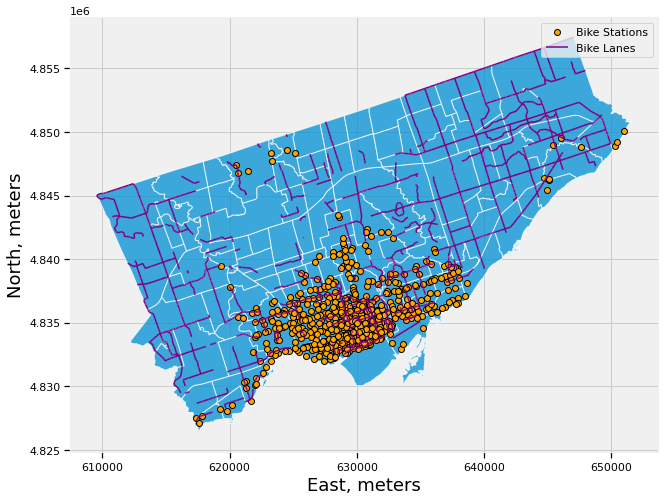

In [ ]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)
bikeshare_stations_gdf.plot(ax=ax, color='orange', edgecolor='k', label='Bike Stations')
bike_lanes.plot(ax=ax, color='purple', label='Bike Lanes');

plt.xlabel('East, meters', fontsize=18)
plt.ylabel('North, meters', fontsize=18)
plt.legend(labels={'Bike Stations','Bike Lanes'})
plt.show()

## 2.2 Neighbourhood Analysis

Calculate the area of each neighbourhood and number of stations (station density) within each neighbourhood.

In [ ]:
neighbourhoods['area'] = neighbourhoods['geometry'].area/ 10**6  #unit is km^2
neighbourhoods['stations'] = ''
neighbourhoods['stations'] = neighbourhoods.apply(lambda row: bikeshare_stations_gdf.within(row['geometry']).sum(),axis=1)

neighbourhoods = neighbourhoods.sort_values(by=['stations'],ascending=False)
neighbourhoods['station_density'] = neighbourhoods['stations']/neighbourhoods['area']

neighbourhoods.head(10)

,name,geometry,area,stations,station_density
61,Waterfront Communities-The Island,"POLYGON ((630894.760 4833934.115, 630991.159 4...",13.416227,60,4.472196
80,Bay Street Corridor,"POLYGON ((630036.375 4834338.263, 630107.574 4...",1.809273,47,25.977279
97,Church-Yonge Corridor,"POLYGON ((630881.766 4835659.785, 630893.584 4...",1.364556,32,23.450846
26,Niagara,"POLYGON ((626833.621 4831957.033, 626830.404 4...",3.241261,31,9.564178
136,Kensington-Chinatown,"POLYGON ((628713.653 4833925.535, 628698.164 4...",1.534607,26,16.942443
49,South Riverdale,"POLYGON ((634788.020 4834074.432, 634789.475 4...",10.964701,22,2.006439
77,Annex,"POLYGON ((629463.304 4836332.300, 629324.313 4...",2.790299,21,7.526075
18,Moss Park,"POLYGON ((632910.604 4834938.350, 632883.548 4...",1.413028,21,14.861704
59,University,"POLYGON ((628394.442 4834951.967, 628330.470 4...",1.405221,20,14.232634
106,Dovercourt-Wallace Emerson-Junction,"POLYGON ((627517.108 4835724.334, 627480.745 4...",3.725831,20,5.367929


## 2.3 Most popular neighbrourhood for departure and arrival

Add neighbourhood info to each station

In [ ]:
!sudo apt install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
!sudo pip3 install rtree

In [ ]:
import rtree

[IMPORTANT] I have installed and imported 'rtree' in the above cells. However, the first time you run this script, it will report an error says missing 'rtree'. In this case, just re-run the whole script, then everything will work. I don't know why, but it works perfectly on the second run.

In [ ]:
from geopandas.tools import geocode

In [ ]:
bikeshare_stations_gdf_temp = ''
bikeshare_stations_gdf_temp = gpd.sjoin(bikeshare_stations_gdf, neighbourhoods, how='left')
bikeshare_stations_gdf_neighbour = (bikeshare_stations_gdf_temp
                                    .drop(columns= {'index_right','stations','station_density','area'
                                    , 'Station Name','lat','lon','capacity','geometry'})
                                    .rename(columns={'name':'neighbourhood'}))
#bikeshare_stations_gdf_neighbour.head()                                                             

In [ ]:
trips_neighbourhoods = trips_data_reset[['Trip Id','Start Station Id','End Station Id','Trip Duration']].reset_index().drop(columns='Start Time')
bikeshare_stations_gdf_neighbour_start = bikeshare_stations_gdf_neighbour.rename(columns={'Station Id':'Start Station Id'})
bikeshare_stations_gdf_neighbour_end = bikeshare_stations_gdf_neighbour.rename(columns={'Station Id':'End Station Id'})

trips_neighbourhoods = trips_neighbourhoods.merge(bikeshare_stations_gdf_neighbour_start,how='left',on='Start Station Id')

trips_neighbourhoods = trips_neighbourhoods.rename(columns={'neighbourhood':'start'})
trips_neighbourhoods = trips_neighbourhoods.merge(bikeshare_stations_gdf_neighbour_end,how='left',on='End Station Id')
trips_neighbourhoods = trips_neighbourhoods.rename(columns={'neighbourhood':'end'})
trips_neighbourhoods.head()

,Trip Id,Start Station Id,End Station Id,Trip Duration,start,end
0,712441,7006,7021,274,Bay Street Corridor,Bay Street Corridor
1,712442,7046,7147,538,Niagara,South Parkdale
2,712443,7048,7089,992,Waterfront Communities-The Island,Church-Yonge Corridor
3,712444,7177,7202,1005,Niagara,Bay Street Corridor
4,712445,7203,7010,645,Niagara,Waterfront Communities-The Island


In [ ]:
trips_neighbourhoods_start = (trips_neighbourhoods.groupby('start').count()
                              .rename(columns={'Trip Id':'trips_start'})
                              .drop(columns=['Start Station Id','End Station Id','end','Trip Duration'])
                              .sort_values(by='trips_start',ascending = False))
trips_neighbourhoods_start.head(10)

,trips_start
start,
Waterfront Communities-The Island,1615756
Bay Street Corridor,1179562
Church-Yonge Corridor,667806
Niagara,625441
Kensington-Chinatown,595749
University,419277
Moss Park,329095
South Parkdale,252711
Annex,242580


In [ ]:
trips_neighbourhoods_end = (trips_neighbourhoods.groupby('end').count()
                              .rename(columns={'Trip Id':'trips_end'})
                              .drop(columns=['Start Station Id','End Station Id','start','Trip Duration'])
                              .sort_values(by='trips_end',ascending = False))
trips_neighbourhoods_end.head(10)

,trips_end
end,
Waterfront Communities-The Island,1722924
Bay Street Corridor,1209410
Niagara,643530
Church-Yonge Corridor,622905
Kensington-Chinatown,603476
University,389726
Moss Park,343516
South Parkdale,261064
South Riverdale,236663


In [ ]:
neighbourhoods_top_start = neighbourhoods[neighbourhoods['name'].isin(trips_neighbourhoods_start.reset_index().iloc[:5].start)]
neighbourhoods_top_end = neighbourhoods[neighbourhoods['name'].isin(trips_neighbourhoods_end.reset_index().iloc[:5].end)]

neighbourhoods_top_end.head(10)

,name,geometry,area,stations,station_density
61,Waterfront Communities-The Island,"POLYGON ((630894.760 4833934.115, 630991.159 4...",13.416227,60,4.472196
80,Bay Street Corridor,"POLYGON ((630036.375 4834338.263, 630107.574 4...",1.809273,47,25.977279
97,Church-Yonge Corridor,"POLYGON ((630881.766 4835659.785, 630893.584 4...",1.364556,32,23.450846
26,Niagara,"POLYGON ((626833.621 4831957.033, 626830.404 4...",3.241261,31,9.564178
136,Kensington-Chinatown,"POLYGON ((628713.653 4833925.535, 628698.164 4...",1.534607,26,16.942443


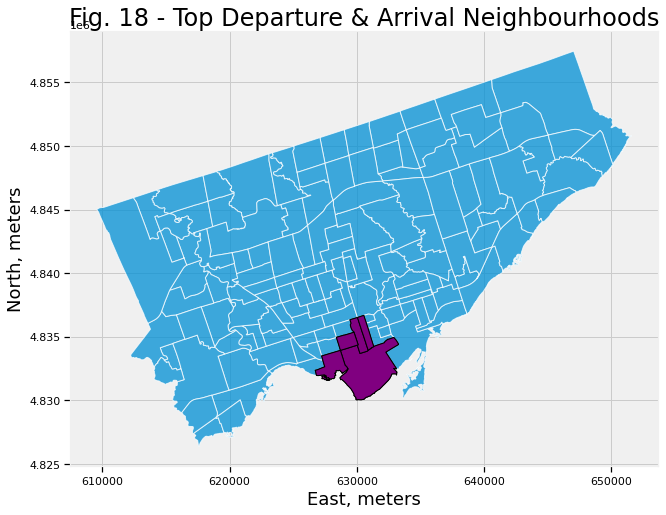

In [ ]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)
neighbourhoods_top_start.plot(ax=ax, color='orange', edgecolor='k', label='Top Start')
neighbourhoods_top_end.plot(ax=ax, color='purple', edgecolor='k', label='Top End')

plt.xlabel('East, meters', fontsize=18)
plt.ylabel('North, meters', fontsize=18)
plt.title('Fig. 18 - Top Departure & Arrival Neighbourhoods', fontsize=24)
plt.show()

The busiest 10 neighbourhoods are plotted above, where the top 10 arrival neighbourhoods are the same as the top 10 departure ones. They are at downtown area, near the lake.

## 2.4 Proximity Analysis

### 2.4.1 Import Folium

In [ ]:
!pip install folium

In [ ]:
import folium

In [ ]:
from folium.plugins import HeatMap

### 2.4.2 Subway Stations Proximity

In [ ]:
from folium import GeoJson
from folium import Marker

In [ ]:
#directory in my google drive, to be changed if running elsewhere.
subway_stations = gpd.read_file('/content/drive/MyDrive/UT/Courses/Winter2021/CIV1498/Project/subway_stations.shp').to_crs(epsg=26917)
#subway_stations.head()

A station is considered as bike accessible if there are bike stations close to it within 200 meters. This part checks which stations have bike access.

In [ ]:
bikeshare_stations_buffer = bikeshare_stations_gdf.geometry.buffer(200)
#bikeshare_stations_buffer.head()
bike_station_union = bikeshare_stations_buffer.geometry.unary_union
bike_station_union = gpd.GeoDataFrame(geometry=[bike_station_union], crs='EPSG:26917')
bike_station_union.head()

,geometry
0,"MULTIPOLYGON (((617802.782 4827154.082, 617801..."


In [ ]:
subway_stations['bike_access_bool'] = subway_stations.apply(lambda row: bikeshare_stations_buffer
                                                            .geometry.contains(row['geometry'])
                                                            .sum(), axis=1)
subway_stations['bike_access'] = subway_stations['bike_access_bool']>0
subway_stations = subway_stations.drop(columns = {'bike_access_bool'})
# View GeoDataFrame
subway_stations.head()

,STATION,LINE,PLATFORM_L,AVG_PASSEN,LINE2,PLATFORM_1,SUBWAY_TRA,ADDRESS,Opened,geometry,bike_access
0,Kipling,Bloor-Danforth,1,53640,None,None,False,5247 Dundas St. West,1980,POINT (618101.613 4832636.300),False
1,Islington,Bloor-Danforth,1,43090,None,None,False,3286 Bloor St. West,1968,POINT (618990.613 4833544.113),False
2,Royal York,Bloor-Danforth,2,19440,None,None,False,3012 Bloor St. West,1968,POINT (620056.496 4833882.764),False
3,Old Mill,Bloor-Danforth,2,5780,None,None,False,2672 Bloor St. West,1968,POINT (621361.678 4834111.901),False
4,Jane,Bloor-Danforth,2,16730,None,None,False,2440 Bloor St. West,1968,POINT (622220.664 4834091.381),True


In [ ]:
# Create map with release incidents and monitoring stations
map_9 = folium.Map(location=[43.6426, -79.3871], 
                   tiles='cartodbpositron', 
                   zoom_start=10)
    
# Plot each polygon on the map
GeoJson(bike_station_union.to_crs(epsg=4326)).add_to(map_9)

# Add points to the map
for idx, row in subway_stations.to_crs(epsg=4326).iterrows():
    if row['bike_access']:
        Marker([row.geometry.y, row.geometry.x], 
               icon=folium.Icon(color='green'),
               popup=row['STATION']).add_to(map_9)
    else:
        Marker([row.geometry.y, row.geometry.x], 
               icon=folium.Icon(color='red'),
               popup=row['STATION']).add_to(map_9)

# Show the map
map_9

In [ ]:
bike_access = subway_stations.bike_access.sum()/subway_stations.shape[0]*100

# Print answer
print('{} Toronto subways stations ({:0.2f} %) are within 200 meters of a bike station.'.format(subway_stations.bike_access.sum(),bike_access))

44 Toronto subways stations (67.69 %) are within 200 meters of a bike station.


From bike station point of view, check if a bike station is within 200 meters of subway stations, and check the usage of those bike stations.

In [ ]:
subway_stations_buffer = subway_stations.geometry.buffer(200)
bikeshare_stations_check = bikeshare_stations_gdf

bikeshare_stations_check['subway_access_bool'] = bikeshare_stations_check.apply(lambda row: subway_stations_buffer.contains(row['geometry']).sum(),axis=1)
bikeshare_stations_check['subway_access'] = bikeshare_stations_check['subway_access_bool']>0
bikeshare_stations_check = bikeshare_stations_check.drop(columns={'subway_access_bool'})
#bikeshare_stations_check.head()

In [ ]:
bikeshare_stations_subway_access = bikeshare_stations_check[['Station Id','subway_access']]
bikeshare_stations_subway_access_start = bikeshare_stations_subway_access.rename(columns = {'Station Id':'Start Station Id'})
bikeshare_stations_subway_access_end = bikeshare_stations_subway_access.rename(columns = {'Station Id':'End Station Id'})


trips_subway = trips_data_reset[['Trip Id','Start Station Id','End Station Id']].reset_index().drop(columns='Start Time')

trips_subway = trips_subway.merge(bikeshare_stations_subway_access_start,how='left',on='Start Station Id').rename(columns={'subway_access':'from_subway'})
trips_subway = trips_subway.merge(bikeshare_stations_subway_access_end,how='left',on='End Station Id').rename(columns={'subway_access':'to_subway'})

trips_subway['subway_access'] = trips_subway['from_subway']+trips_subway['to_subway'] >0

trips_subway_bike_station = trips_subway[['Trip Id','subway_access']]

#trips_subway_bike_station.head()

In [ ]:
trips_subway_percentage = trips_subway_bike_station.subway_access.sum()/trips_subway_bike_station['Trip Id'].value_counts().sum()*100
print('{:0.2f} % of trips are departing from or arriving at subway stations.'.format(trips_subway_percentage))

34.78 % of trips are departing from or arriving at subway stations.


### 2.4.3 Usage Comparison - Close to TTC Stations or Not

Check if a trip starts or ends at a subway station. If it does, then subway_access_bool will returns a True. Then, all the trips are resampled on an averaged hourly basis, where trips have access to subways will be distinguished with those not. 

In [ ]:
bikeshare_stations_check_bool_for_merge = bikeshare_stations_check[['Station Id', 'subway_access']]
bikeshare_stations_check_bool_for_merge_start = bikeshare_stations_check_bool_for_merge.rename(columns={'Station Id':'Start Station Id'})
bikeshare_stations_check_bool_for_merge_end = bikeshare_stations_check_bool_for_merge.rename(columns={'Station Id':'End Station Id'})

trips_data_subway_access = trips_data_reset[['Trip Id','Start Station Id','End Station Id']].reset_index()
trips_data_subway_access = trips_data_subway_access.merge(bikeshare_stations_check_bool_for_merge_start,how='left',on='Start Station Id')
trips_data_subway_access = trips_data_subway_access.merge(bikeshare_stations_check_bool_for_merge_end,how='left',on='End Station Id')
trips_data_subway_access['subway_access_bool'] = trips_data_subway_access['subway_access_x'] + trips_data_subway_access['subway_access_y'] > 0
trips_data_subway_access = trips_data_subway_access.drop(columns = ['Trip Id','Start Station Id','End Station Id', 'subway_access_x','subway_access_y'])
trips_data_subway_access

,Start Time,subway_access_bool
0,2017-01-01 00:03:00-05:00,False
1,2017-01-01 00:03:00-05:00,False
2,2017-01-01 00:05:00-05:00,True
3,2017-01-01 00:09:00-05:00,False
4,2017-01-01 00:14:00-05:00,False
...,...,...
7834471,2020-09-30 23:59:00-05:00,False
7834472,2020-09-30 23:59:00-05:00,False
7834473,2020-09-30 23:59:00-05:00,False
7834474,2020-09-30 23:59:00-05:00,False


In [ ]:
trips_data_have_subway_access = trips_data_subway_access[trips_data_subway_access['subway_access_bool']==True]
trips_data_no_subway_access = trips_data_subway_access[trips_data_subway_access['subway_access_bool']==False]

trips_data_have_subway_access_resample = trips_data_have_subway_access.groupby(trips_data_have_subway_access['Start Time'].dt.floor('h')).agg(len)
trips_data_no_subway_access_resample = trips_data_no_subway_access.groupby(trips_data_no_subway_access['Start Time'].dt.floor('h')).agg(len)
trips_data_have_subway_access_resample = trips_data_have_subway_access_resample.drop(columns = ['Start Time']).rename(columns={'subway_access_bool':'trips_have_access'}).reset_index()
trips_data_no_subway_access_resample = trips_data_no_subway_access_resample.drop(columns = ['Start Time']).rename(columns={'subway_access_bool':'trips_no_access'}).reset_index()

trips_data_have_subway_access_mean = trips_data_have_subway_access_resample.groupby(trips_data_have_subway_access_resample['Start Time'].dt.hour).mean()
trips_data_no_subway_access_mean = trips_data_no_subway_access_resample.groupby(trips_data_no_subway_access_resample['Start Time'].dt.hour).mean()


In [ ]:
trips_data_subway_access_plot = trips_data_have_subway_access_mean / bikeshare_stations_check_bool_for_merge['subway_access'].sum()
trips_data_subway_access_plot['trips_no_access'] = trips_data_no_subway_access_mean['trips_no_access'] / (bikeshare_stations_check_bool_for_merge.shape[0]-bikeshare_stations_check_bool_for_merge['subway_access'].sum())
#trips_data_subway_access_plot

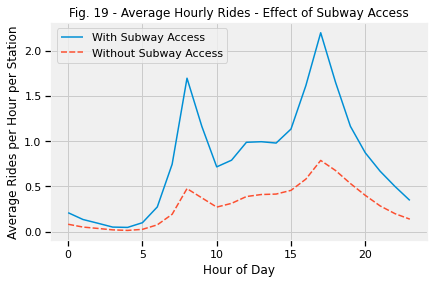

In [ ]:
ax = sns.lineplot(data=trips_data_subway_access_plot)

ax.set_ylabel('Average Rides per Hour per Station')
ax.set_xlabel('Hour of Day')
ax.set_title('Fig. 19 - Average Hourly Rides - Effect of Subway Access')
ax.legend(labels=['With Subway Access','Without Subway Access'])

plt.show()

From the above plot, it is concluded that bikeshare stations that are close to the subway stations will have more usage than other bikeshare stations, specifically in rush hours.

### 2.4.4 Bike Lanes

Add a buffer to bike lanes, and if it is close to any bike stations within 50 meters, which means it will have higher probability to be used. Therefore, the bikelanes connected to more bike stations will be more congested.

In [ ]:
bike_lanes_buffer = bike_lanes.geometry.buffer(200)

In [ ]:
bikeshare_stations_lanes = gpd.GeoDataFrame(bikeshare_stations)
bikeshare_stations_lanes = bikeshare_stations_lanes.to_crs(epsg=26917)

bike_lanes_station_access = bike_lanes
bike_lanes_station_access['bike_station_access'] =0

for j in range(bikeshare_stations_lanes.shape[0]):
  bike_lanes_station_access.bike_station_access = (bike_lanes_station_access.bike_station_access 
                                                   + bike_lanes_buffer.contains(
                                                       bikeshare_stations_lanes.iloc[j].geometry))

bike_lanes_station_access = bike_lanes_station_access.sort_values(
                                  'bike_station_access',ascending=False)

In [ ]:
bike_lanes_station_access.head(10)

,name,route_type,length,geometry,bike_station_access
4850,BREMNER BLVD,bike lane,647.35180,"LINESTRING (629004.780 4832998.873, 629618.936...",7
5366,BLOOR ST W,bike lane,51.17272,"LINESTRING (630003.262 4836496.242, 629954.292...",7
5365,BLOOR ST W,bike lane,124.78200,"LINESTRING (629954.292 4836481.393, 629834.890...",7
4542,SIMCOE ST,bike lane,148.56891,"LINESTRING (630250.397 4833687.357, 630204.046...",6
4336,BEVERLEY ST,bike lane,200.92582,"LINESTRING (629405.941 4835026.151, 629342.864...",6
4273,GERRARD ST W,bike lane,233.16045,"LINESTRING (630453.561 4835282.468, 630230.986...",6
4930,BAY,bike lane,150.99463,"LINESTRING (630828.048 4833525.828, 630779.678...",6
5367,BLOOR ST W,bike lane,51.90925,"LINESTRING (630052.938 4836511.304, 630003.262...",6
4270,ST GEORGE ST,bike lane,75.48601,"LINESTRING (629298.027 4835274.156, 629301.919...",6
4549,SIMCOE ST,bike lane,277.26791,"LINESTRING (630337.260 4833424.073, 630250.397...",6


The above bike_lanes_station_access gives the number of bike stations that are accessible to each bike lane. 

In [ ]:
bike_lanes_station_access = bike_lanes_station_access.reset_index().rename(columns={'index':'bike_lane_id'})
bike_lanes_station_access.head()

,bike_lane_id,name,route_type,length,geometry,bike_station_access
0,4850,BREMNER BLVD,bike lane,647.35180,"LINESTRING (629004.780 4832998.873, 629618.936...",7
1,5366,BLOOR ST W,bike lane,51.17272,"LINESTRING (630003.262 4836496.242, 629954.292...",7
2,5365,BLOOR ST W,bike lane,124.78200,"LINESTRING (629954.292 4836481.393, 629834.890...",7
3,4542,SIMCOE ST,bike lane,148.56891,"LINESTRING (630250.397 4833687.357, 630204.046...",6
4,4336,BEVERLEY ST,bike lane,200.92582,"LINESTRING (629405.941 4835026.151, 629342.864...",6


In [ ]:
bike_lanes_plot = bike_lanes.reset_index().rename(columns={'index':'bike_lane_id'})
bike_lanes_plot = bike_lanes_plot[bike_lanes_plot['bike_lane_id'].isin(bike_lanes_station_access.iloc[:20].bike_lane_id)]
bike_lanes_plot = gpd.GeoDataFrame(bike_lanes_plot)

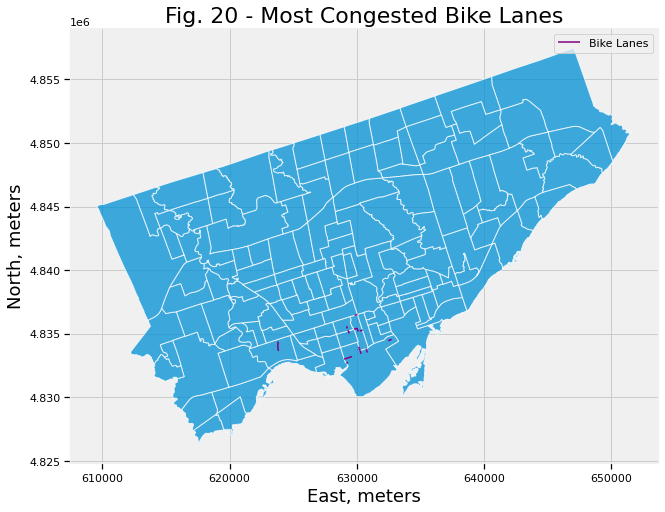

In [ ]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)
bike_lanes_plot.plot(ax=ax, color='purple', label='Bike Lanes');

plt.xlabel('East, meters', fontsize=18)
plt.ylabel('North, meters', fontsize=18)
plt.title('Fig. 20 - Most Congested Bike Lanes' ,fontsize=22)
plt.legend(labels={'Bike Lanes'})
plt.show()

The top 20 busiest bike lanes are plotted on the map, which have the access to the most number of stations. Again, they are mainly located in downtown Toronto.

In [ ]:
bikeshare_stations_buffer_for_lanes = bikeshare_stations_buffer
bikeshare_stations_lanes_for_check = bikeshare_stations_lanes
bikeshare_stations_lanes_for_check['lane_access_bool'] = 0
for i in range(bike_lanes.shape[0]):
  bikeshare_stations_lanes_for_check['lane_access_bool'] = bikeshare_stations_lanes_for_check['lane_access_bool'] + bikeshare_stations_buffer_for_lanes.intersects(bike_lanes.geometry.iloc[i])
bikeshare_stations_lanes_for_check['lane_access'] = bikeshare_stations_lanes_for_check['lane_access_bool'] > 0

bikeshare_stations_lanes_for_check.head()

,Station Id,Station Name,lat,lon,capacity,geometry,lane_access_bool,lane_access
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35,POINT (629379.194 4833121.050),1,True
1,7001,Lower Jarvis St / The Esplanade,43.647830,-79.370698,15,POINT (631398.881 4834049.011),0,False
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19,POINT (629039.989 4836169.986),5,True
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15,POINT (628771.730 4836145.373),0,False
4,7004,University Ave / Elm St,43.656518,-79.389099,11,POINT (629896.139 4834984.957),0,False


In [ ]:
bikeshare_stations_lane_access_for_merge = bikeshare_stations_lanes_for_check[['Station Id','lane_access']].rename(columns={'Station Id':'Start Station Id'})

trips_data_lane_access = trips_data_reset[['Trip Id','Start Station Id']].reset_index()
trips_data_lane_access = trips_data_lane_access.merge(bikeshare_stations_lane_access_for_merge,how='left',on='Start Station Id')

trips_data_have_lane_access = trips_data_lane_access[trips_data_lane_access['lane_access']==True]

trips_data_have_lane_access_resample = trips_data_have_lane_access.groupby(trips_data_have_lane_access['Start Time'].dt.floor('h')).agg({'Trip Id': len}).reset_index()
trips_data_have_lane_access_plot = trips_data_have_lane_access_resample.groupby(trips_data_have_lane_access_resample['Start Time'].dt.hour).mean()
trips_data_have_lane_access_plot = trips_data_have_lane_access_plot.rename(columns={'Trip Id':'trips_access_lanes'})

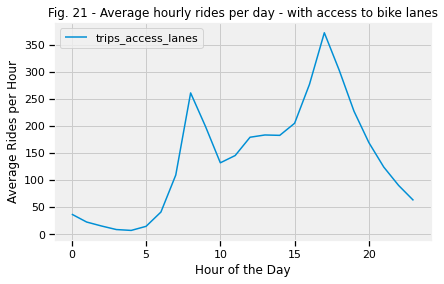

In [ ]:
ax = sns.lineplot(data=trips_data_have_lane_access_plot)

ax.set_ylabel('Average Rides per Hour')
ax.set_xlabel('Hour of the Day')
ax.set_title('Fig. 21 - Average hourly rides per day - with access to bike lanes')
#ax.legend(labels=['Annual Members','Casual Members'])

plt.show()

Generally, rush hours have more trips that use bike lanes, and the peak hour is 5pm. Therefore, if people are riding along the bike lanes, 5pm will be the time that the lanes will be the most congested. 

## 2.5 Trip Duration - Geographic Trend

In [ ]:
trips_duration_neighbourhoods = trips_neighbourhoods

In [ ]:
trips_duration_neighbourhoods_start_mean = trips_duration_neighbourhoods.groupby('start').mean().sort_values('Trip Duration',ascending=False).drop(columns={'Trip Id','Start Station Id','End Station Id'})
trips_duration_neighbourhoods_end_mean = trips_duration_neighbourhoods.groupby('end').mean().sort_values('Trip Duration',ascending=False).drop(columns={'Trip Id','Start Station Id','End Station Id'})

In [ ]:
trips_duration_neighbourhoods_start_mean.head(10)

,Trip Duration
start,
Morningside,1391.504512
Flemingdon Park,1338.850397
Highland Creek,1288.508929
Rouge,1277.176622
Westminster-Branson,1273.192982
West Hill,1260.941504
Long Branch,1260.909561
Lawrence Park North,1243.727412
Bridle Path-Sunnybrook-York Mills,1236.182271


In [ ]:
trips_duration_neighbourhoods_end_mean.head(10)

,Trip Duration
end,
Flemingdon Park,1365.290991
Morningside,1351.865730
New Toronto,1331.376404
Highland Creek,1316.140351
West Hill,1307.525510
Rouge,1277.339455
Westminster-Branson,1253.637689
Humber Heights-Westmount,1235.322799
Bathurst Manor,1222.634701


In [ ]:
neighbourhoods_top_duration_start = neighbourhoods[neighbourhoods['name'].isin(trips_duration_neighbourhoods_start_mean.reset_index().iloc[:10].start)]
neighbourhoods_top_duration_end = neighbourhoods[neighbourhoods['name'].isin(trips_duration_neighbourhoods_end_mean.reset_index().iloc[:10].end)]

#neighbourhoods_top_end.head(10)

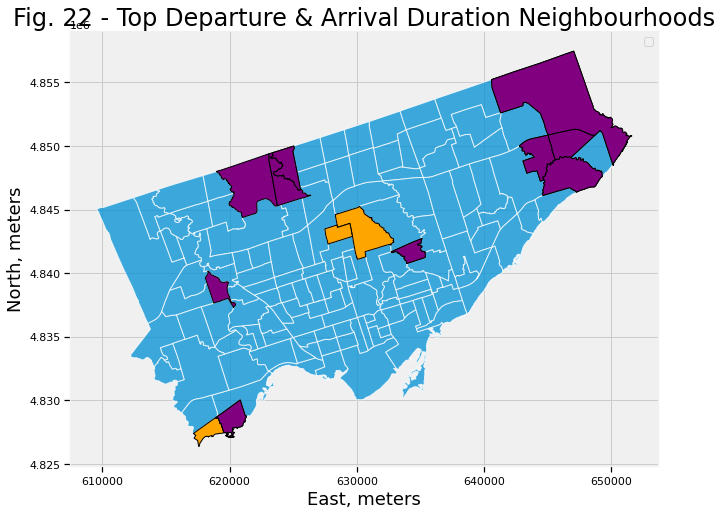

In [ ]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)
neighbourhoods_top_duration_start.plot(ax=ax, color='orange', edgecolor='k', label='Top Start')
neighbourhoods_top_duration_end.plot(ax=ax, color='purple', edgecolor='k', label='Top End')

plt.xlabel('East, meters', fontsize=18)
plt.ylabel('North, meters', fontsize=18)
plt.legend(labels={'Start','End'})
plt.title('Fig. 22 - Top Departure & Arrival Duration Neighbourhoods', fontsize=24)
plt.show()

It turns out that the longest duration neighbourhoods are far from downtown Toronto region, where the density of the bike stations are high. Due to the low density, the trip durations tend to be higher. 
Orange - trips starts at;
Purple - trips ends at. (there are many overlaps)


# 3.0 Summary

In this section, the questions from the City of Toronto have been answered with the above exploratory data analyses. The answers are summarized in this sections, while details can be obtained from corresponding analysis.
1. There is an increasing trend of usage of the bikeshare system from 2017 to 2020, and the increasing trends are the same for both annual members and casual members. (Section 1.3 - Fig.1)
2. The usage behaviour between annal members and casual members are different. Annual members tend to use it during the weekdays, while casual members tend to use on weekends. (Section 1.5 - Fig. 4)
3. The neigbourhood - Waterfront Communities-The Island - sees the largest number of rides both departing from and arriving at. Furthermore, the top 10 neigbourhoods that have the largest number of rides are almost the same for trips departing from and arriving at, and these neighbourhoods concentrated at downtown Toronto near the lake (Section 2.3 - Fig. 18).
4. Free rides Wednesday happens in September, which significantly increases the casual members usage on Wednesdays during Septembers, while a small decrease of annual members on Wednesdays (Section 1.8 - Fig. 9 & 10). 
5. People tend to ride on clear days, while days with precipitations will see significant reduction of the number of usage (Section 1.9 - Fig. 11).
6. The weather features will combine with each other when affecting the usage of the system, from the observations, it turns out that wind speed and temperature are the most influential ones (Section 1.9 - Fig. 12-17).
7. Generally, there are more usage of the bikeshare system during the summer comparing to the winter, which can be observed from Fig. 6 (Section 1.5); and annual members and casual members demonstrate similar useage behaviours, except for the annual members tend to use the system more than the casual members. On a weekly basis, the annual members tend to use the system more during the weekdays, while casual members tend to use the system more during the weekends (Fig. 4). On a daily basis, annual members tend to use the system more during rush hours on weekdays; while their trend of usage on weekends are similar to that of the casual members. It is worth mentioning that annual members still use the system more than the casual members during the weekends (Fig. 5).
8. When the pandemic hit and the government announced the lockdown, the usage see a significant drop (including the begining of the second wave), since most people starts to work from home. But as the lockdown rules releases, the usage sees a siginificant rebound during the summer time. (Section 1.4 - Fig. 2)  
9. The usage of the statutory holidays decreases significanly, comparing to regular weekends. It seems people does not tend to ride on holidays. (Section 1.7 - Fig.8)
10. The usage of the system does depend on the proximity to TTC stations. Bikeshare stations close to TTC stations tends to see more usage, especially during rush hours. (Section 2.4.3 - Fig. 19)
11. There are seasonal and geographical trends in trip durations. People tend to ride the system longer at months with higher temperatures; and people tend to ride longer when far away from downtown Toronto (where the bikestation are far aparts from each others). It is worth mentioning that casual members tend to ride longer than annual members. (Section 1.6 - Fig. 7 & Section 2.5 - Fig. 22)
12. The most congested bikelanes will be along Bremner Blvd and Bloor St. W., while the congestion will most likely happens around 5pm (rush hour) (Section 2.4.4 - Fig. 20-12). 
13. Based on the analyses, only 34.78 % of trips are departing from or arriving at subway stations, which means people does not tend to use the system to access TTC stations. (Section 2.4.2)
14. The usage of the system is analyzed based on the hour of usage, where trips within the rush hours are deemed for commute, while other trips are for exploration of the city. From the analyses, 64.42 % of trips are out of the rush hours; therefore, people tend to use the system more to explore the city. (Section 1.10)
